# 6.6 Sourcing & Analyzing Time-Series Data

### This script contains the following:

#### 1. Importing your libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the JODI Oil World Database

### 1. Importing your libraries and data

In [2]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [3]:
# Configure API key 

quandl.ApiConfig.api_key = '_yTHx6r5fQd8CUFTFbu7'

In [38]:
# Importing the Federal Reserve Economic Data "Civilian Labor Force Participation Rate" variable.

data = quandl.get('FRED/CPILFESL')

The Civilian Labor Force Participation Rate (CLFPR) measures the proportion of the working-age population actively engaged in the labor force.
It is calculated by dividing the number of employed and job-seeking individuals by the total working-age population, indicating economic health and workforce participation trends.

In [39]:
data.head(5)

,Value
Date,
1957-01-01,28.5
1957-02-01,28.6
1957-03-01,28.7
1957-04-01,28.8
1957-05-01,28.8


In [40]:
data.shape

(781, 1)

In [41]:
data.columns

Index(['Value'], dtype='object')

In [42]:
type(data)

pandas.core.frame.DataFrame

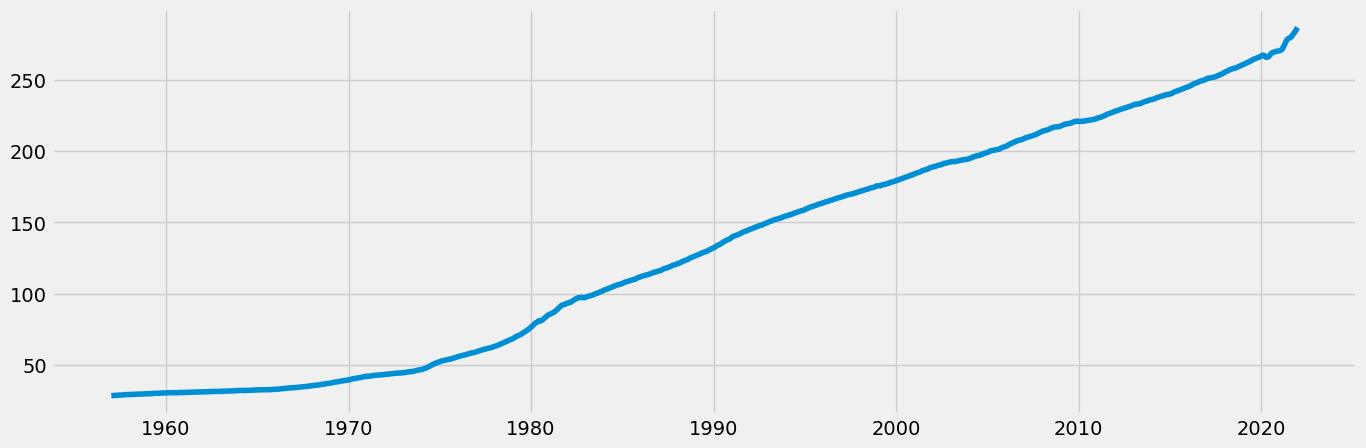

In [43]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

In [44]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [45]:
data_2.head()

,Date,Value
0,1957-01-01,28.5
1,1957-02-01,28.6
2,1957-03-01,28.7
3,1957-04-01,28.8
4,1957-05-01,28.8


In [46]:
#  Subset values after January 1980 and before June 2020

data_sub = data_2.loc[(data_2['Date'] >= '1980-01-01') & (data_2['Date'] < '2020-06-01')]

In [47]:
data_sub.head()

,Date,Value
276,1980-01-01,76.7
277,1980-02-01,77.5
278,1980-03-01,78.6
279,1980-04-01,79.5
280,1980-05-01,80.1


In [48]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
1980-01-01,76.7
1980-02-01,77.5
1980-03-01,78.6
1980-04-01,79.5
1980-05-01,80.1


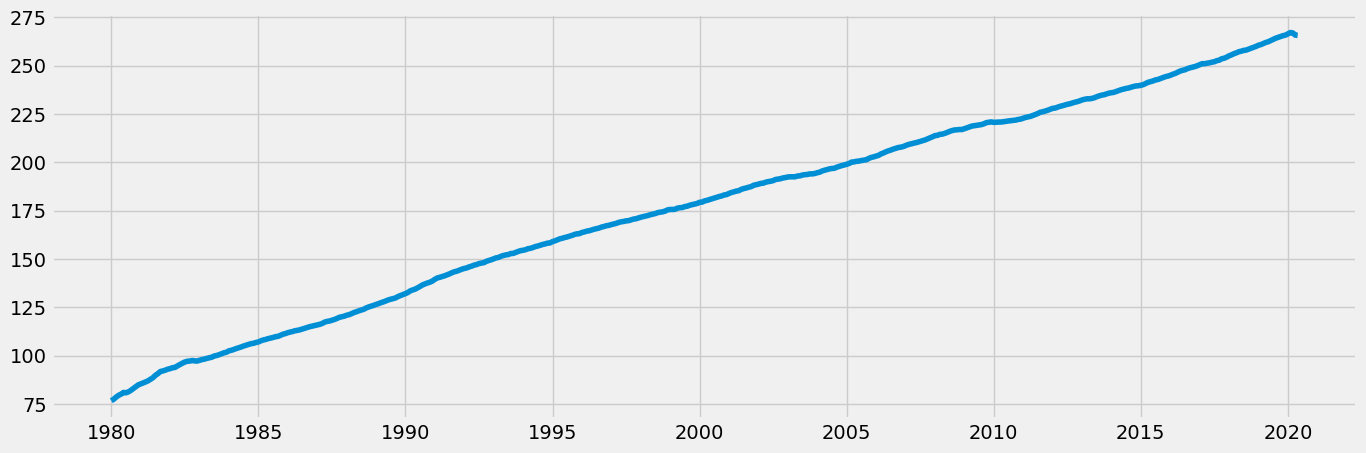

In [49]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [50]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum()

Value    0
dtype: int64

In [51]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

# 5 duplicates

5

In [52]:
# Excluding duplicates

no_dups = dups.drop_duplicates()

In [53]:
# Check for duplicates

no_dups.sum() # 1 duplicate left

1

### 3. Time-series analysis: decomposition

In [54]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [55]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

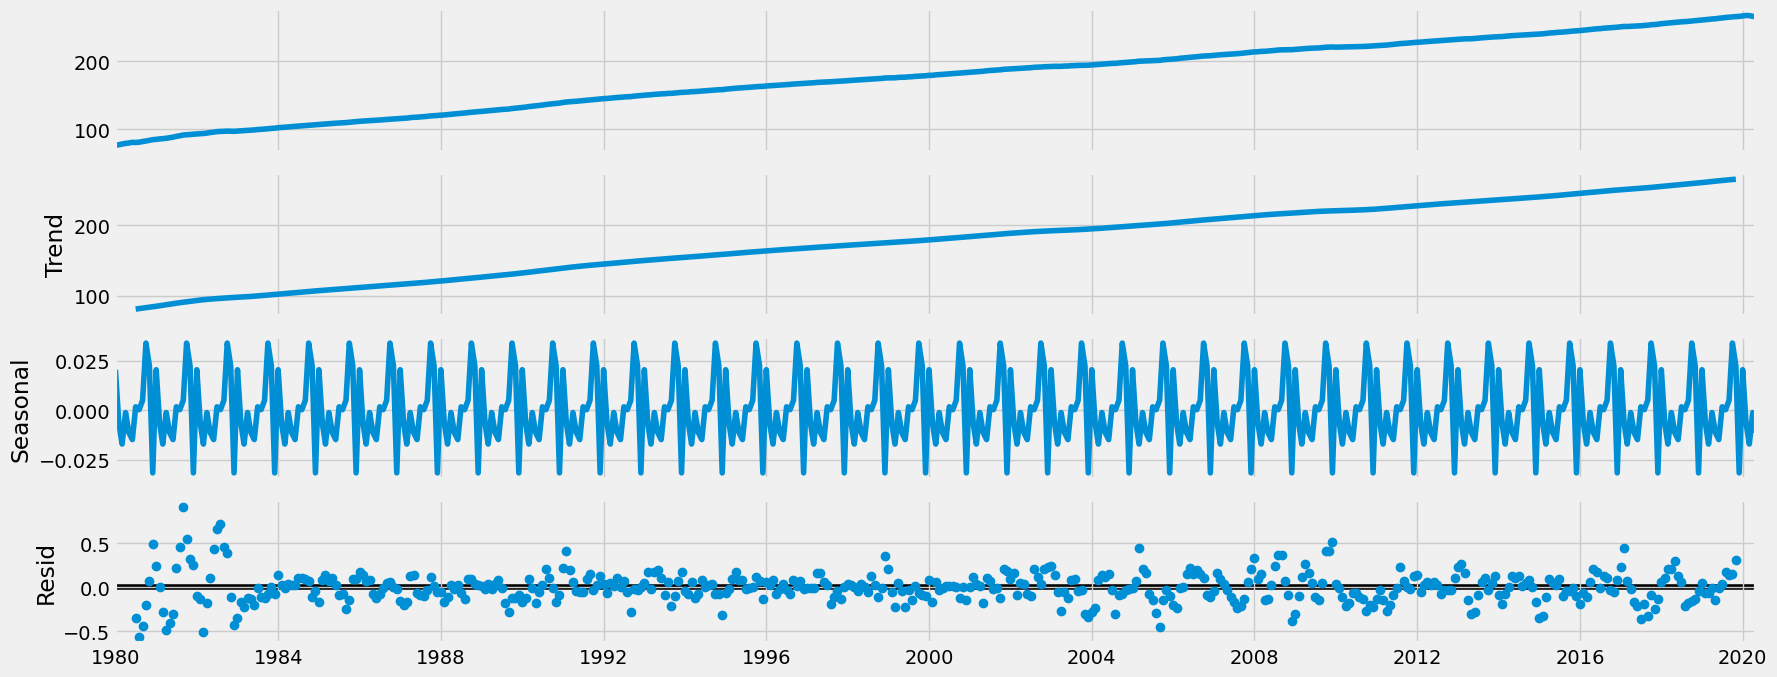

In [56]:
# Plot the separate components

decomposition.plot()
plt.show()

####Observations:

- We can clearly see a higher trend of the civilian labor rate over the years
- The higher participation rate generally suggests a healthier economy with more people actively engaged in the labor market

### 4. Testing for stationarity

In [60]:
# The adfuller() function will import from the model from statsmodels for the test; however,
# running it will only return an array of numbers.
# This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series

dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -2.908099
p-value                          0.044414
Number of Lags Used              2.000000
Number of Observations Used    482.000000
Critical Value (1%)             -3.443990
Critical Value (5%)             -2.867555
Critical Value (10%)            -2.569974
dtype: float64


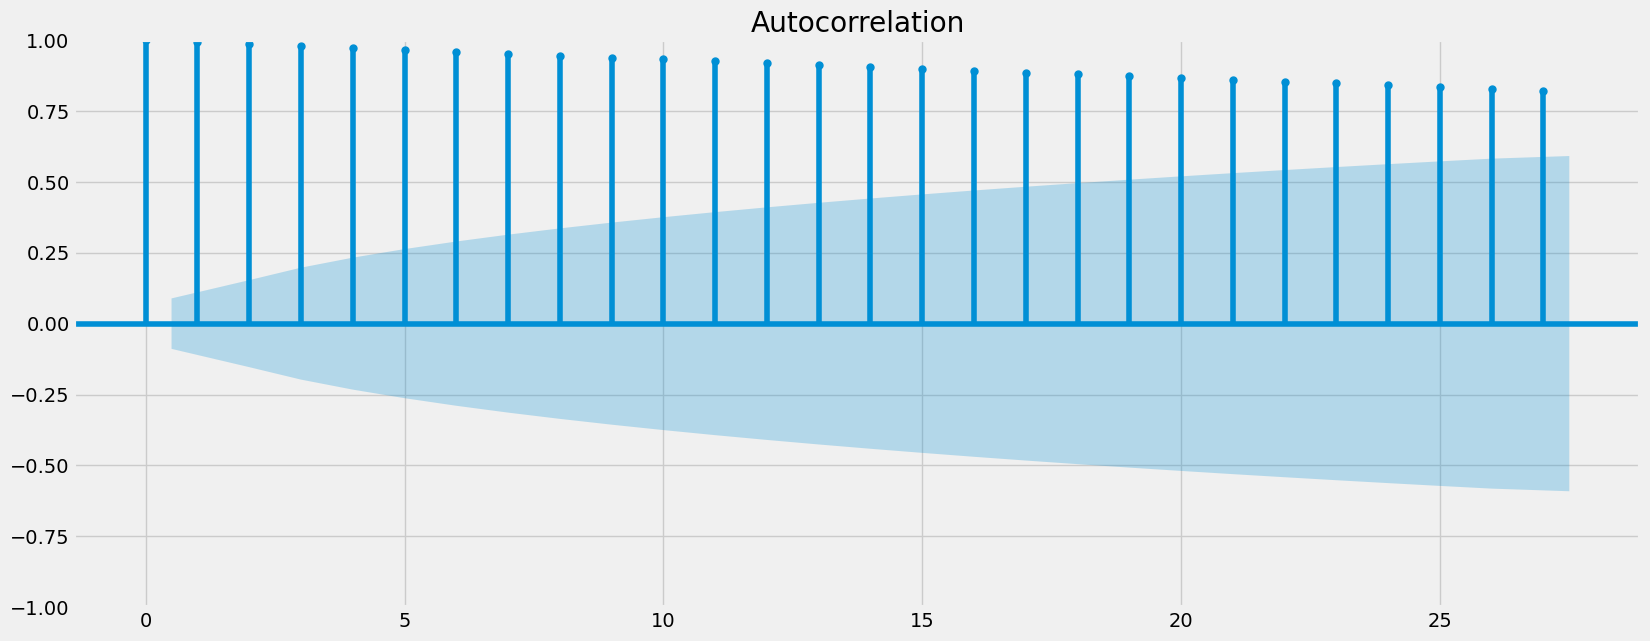

In [58]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

####Observations:

- The Dickey-Fuller test shows a p-value below 0.05
- The Test Statistic is also smaller than the Critical Value (5%)

We can reject the null hypothesis


### 5. Stationarizing the Federal Reserve Economic Data

In [61]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [62]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [63]:
data_diff.head()

,Value
datetime,
1980-02-01,0.8
1980-03-01,1.1
1980-04-01,0.9
1980-05-01,0.6
1980-06-01,0.9


In [64]:
data_diff.columns

Index(['Value'], dtype='object')

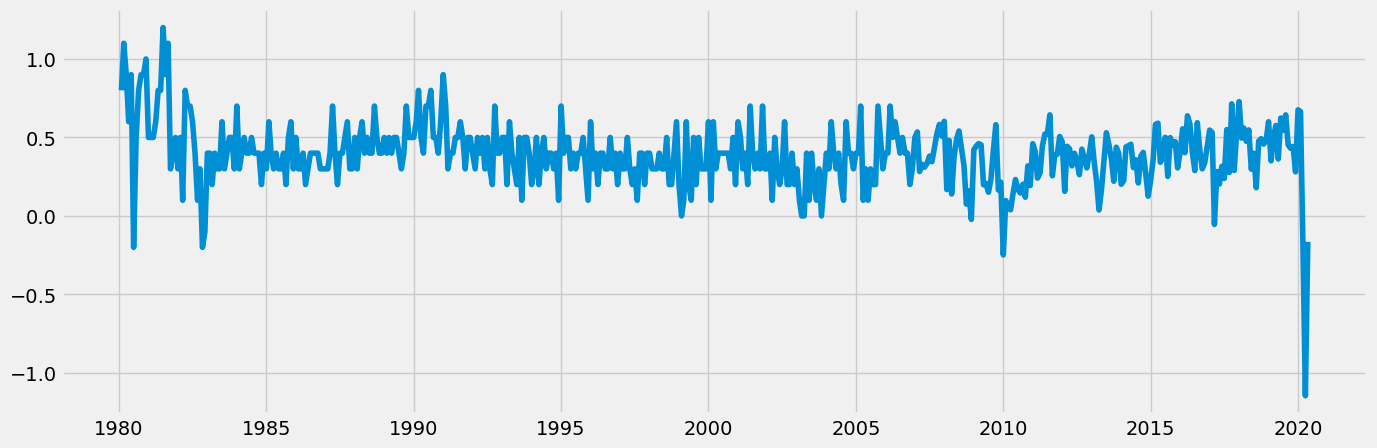

In [65]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [66]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -4.864867
p-value                          0.000041
Number of Lags Used              5.000000
Number of Observations Used    478.000000
Critical Value (1%)             -3.444105
Critical Value (5%)             -2.867606
Critical Value (10%)            -2.570001
dtype: float64


####Observations:

- The differencing method confirms the Test Statistic at a smaller level than the Critical Value at both the five and ten percent significance levels
- We can reiterate that the null hypothesis is rejected and that the CLFPR data series is stationary

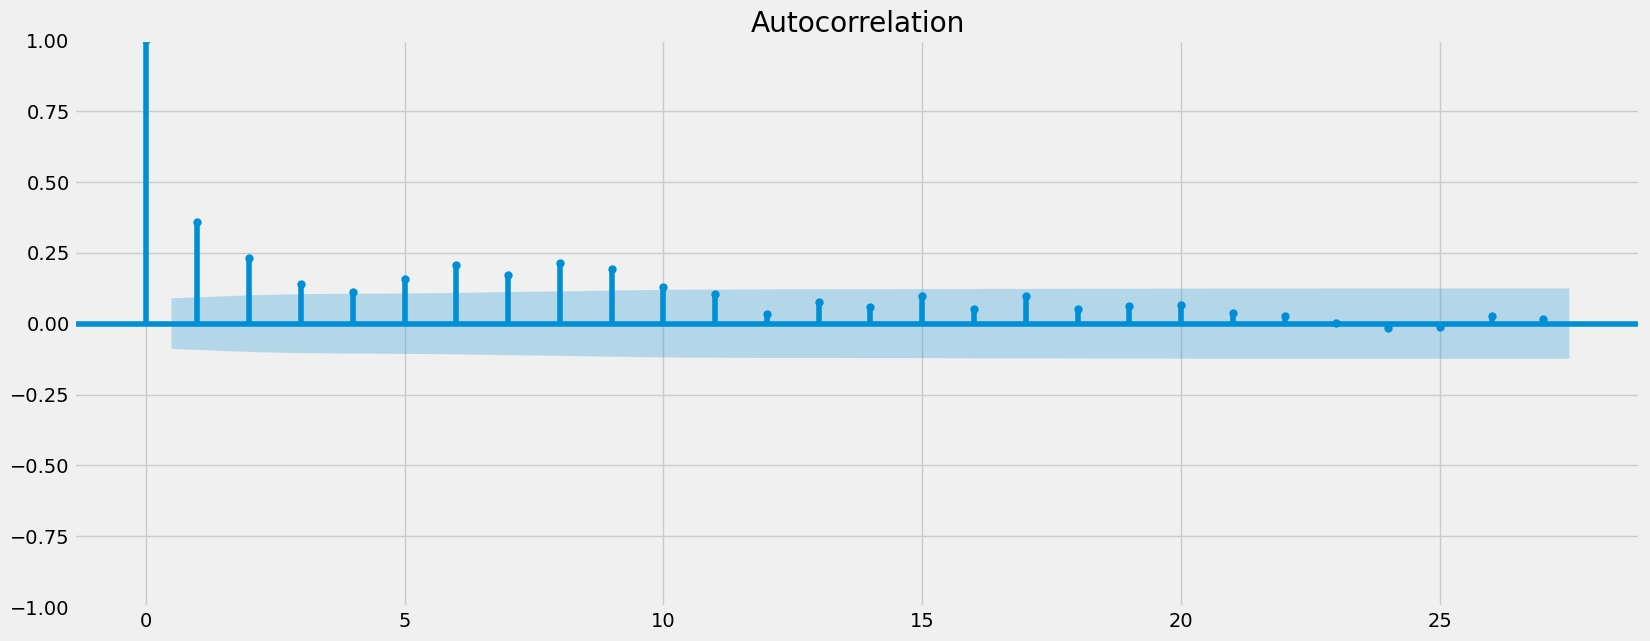

In [67]:
plot_acf(data_diff)
plt.show()